In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import string
import unicodedata
from io import open
import glob
import os
import time
import random
import numpy as np
from typing import List, Tuple, Set, Optional
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy.typing as npt

# Check if CUDA is available
device: torch.device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cpu


In [2]:
allowed_characters: str = string.ascii_letters + " .,;'" + "_"
n_letters: int = len(allowed_characters)

def unicodeToAscii(s: str) -> str:
    """Convert Unicode string to ASCII, filtering allowed characters."""
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [3]:
print (f"converting 'Ślusàrski' to {unicodeToAscii('Ślusàrski')}")

converting 'Ślusàrski' to Slusarski


In [4]:
def letterToIndex(letter: str) -> int:
    """
    Find letter index from allowed_characters.
    Returns index of '_' for out-of-vocabulary characters.
    """
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)

def lineToTensor(line: str) -> torch.Tensor:
    """
    Turn a line into a <line_length x 1 x n_letters> tensor,
    or an array of one-hot letter vectors.
    """
    tensor: torch.Tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print (f"The letter 'a' becomes {lineToTensor('a')}") #notice that the first position in the tensor = 1
print (f"The name 'Ahn' becomes {lineToTensor('Ahn')}") #notice 'A' sets the 27th index to 1

The letter 'a' becomes tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]])
The name 'Ahn' becomes tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [5]:
class NamesDataset(Dataset):
    """Dataset for loading names from text files organized by language/origin."""
    def __init__(self, data_dir: str) -> None:
        self.data_dir: str = data_dir #for provenance of the dataset
        self.load_time: time.struct_time = time.localtime() #for provenance of the dataset
        labels_set: Set[str] = set() #set of all classes

        self.data: List[str] = []
        self.data_tensors: List[torch.Tensor] = []
        self.labels: List[str] = []
        self.labels_tensors: List[torch.Tensor] = []

        #read all the ``.txt`` files in the specified directory
        text_files: List[str] = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label: str = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines: List[str] = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        #Cache the tensor representation of the labels
        self.labels_uniq: List[str] = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor: torch.Tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, str, str]:
        data_item: str = self.data[idx]
        data_label: str = self.labels[idx]
        data_tensor: torch.Tensor = self.data_tensors[idx]
        label_tensor: torch.Tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

In [6]:
alldata: NamesDataset = NamesDataset("data/names")
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 20074 items of data
example = (tensor([2]), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [7]:
train_set, test_set = torch.utils.data.random_split(
    alldata, 
    [.85, .15], 
    generator=torch.Generator(device=device).manual_seed(2024)
)

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 17063, validation examples = 3011


In [8]:
class CharRNN(nn.Module):
    """Character-level RNN for name classification."""
    def __init__(self, input_size: int, hidden_size: int, output_size: int) -> None:
        super(CharRNN, self).__init__()

        self.rnn: nn.RNN = nn.RNN(input_size, hidden_size)
        self.h2o: nn.Linear = nn.Linear(hidden_size, output_size)
        self.softmax: nn.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor: torch.Tensor) -> torch.Tensor:
        rnn_out: torch.Tensor
        hidden: torch.Tensor
        rnn_out, hidden = self.rnn(line_tensor)
        output: torch.Tensor = self.h2o(hidden[0])
        output = self.softmax(output)

        return output

In [9]:
n_hidden: int = 128
rnn: CharRNN = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq))
print(rnn)

CharRNN(
  (rnn): RNN(58, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [10]:
def label_from_output(output: torch.Tensor, output_labels: List[str]) -> Tuple[str, int]:
    """Extract the most likely label from model output."""
    top_n: torch.Tensor
    top_i: torch.Tensor
    top_n, top_i = output.topk(1)
    label_i: int = top_i[0].item()
    return output_labels[label_i], label_i


input_tensor: torch.Tensor = lineToTensor('Albert')
output: torch.Tensor = rnn(input_tensor)
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-2.9240, -2.9664, -2.8905, -2.9793, -2.9997, -2.8769, -2.9208, -2.8461,
         -2.9038, -2.8152, -2.9844, -2.9064, -2.7845, -2.8191, -2.8395, -2.9161,
         -2.8343, -2.8541]], grad_fn=<LogSoftmaxBackward0>)
('English', 12)


In [11]:
def train(
    rnn: CharRNN, 
    training_data: torch.utils.data.Subset, 
    n_epoch: int = 10, 
    n_batch_size: int = 64, 
    report_every: int = 50, 
    learning_rate: float = 0.2, 
    criterion: nn.Module = nn.NLLLoss()
) -> List[float]:
    """
    Learn on a batch of training_data for a specified number of iterations 
    and reporting thresholds.
    """
    # Keep track of losses for plotting
    current_loss: float = 0.0
    all_losses: List[float] = []
    rnn.train()
    optimizer: torch.optim.SGD = torch.optim.SGD(rnn.parameters(), lr=learning_rate)
    
    start: float = time.time()
    print(f"training on data set with n = {len(training_data)}")
    
    for iter in range(1, n_epoch + 1):
        rnn.zero_grad()
        
        # Create minibatches
        batches_indices: List[int] = list(range(len(training_data)))
        random.shuffle(batches_indices)
        batches: List[npt.NDArray[np.int_]] = np.array_split(
            batches_indices, 
            len(batches_indices) // n_batch_size
        )
        
        for idx, batch in enumerate(batches):
            batch_loss: torch.Tensor = torch.tensor(0.0)
            for i in batch:
                label_tensor: torch.Tensor
                text_tensor: torch.Tensor
                label: str
                text: str
                (label_tensor, text_tensor, label, text) = training_data[i]
                output: torch.Tensor = rnn.forward(text_tensor)
                loss: torch.Tensor = criterion(output, label_tensor)
                batch_loss += loss
            
            # Optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()
            
            current_loss += batch_loss.item() / len(batch)
        
        all_losses.append(current_loss / len(batches))
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0.0
    
    return all_losses

In [12]:
start: float = time.time()
all_losses: List[float] = train(rnn, train_set, n_epoch=27, learning_rate=0.15, report_every=5)
end: float = time.time()
print(f"training took {end-start}s")

training on data set with n = 17063
5 (19%): 	 average batch loss = 0.8911239913462766
10 (37%): 	 average batch loss = 0.7036155277918087
15 (56%): 	 average batch loss = 0.5849141215367977
20 (74%): 	 average batch loss = 0.5029432659551821
25 (93%): 	 average batch loss = 0.4440871454219449
training took 662.9179763793945s


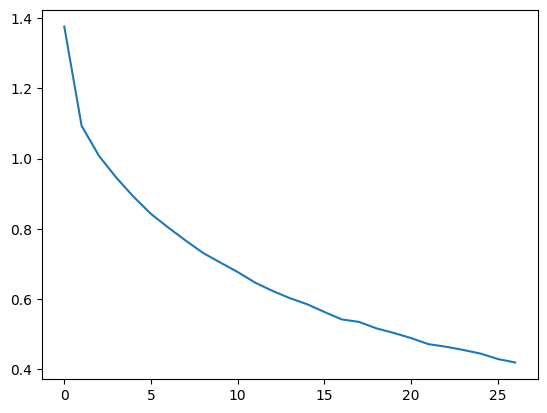

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

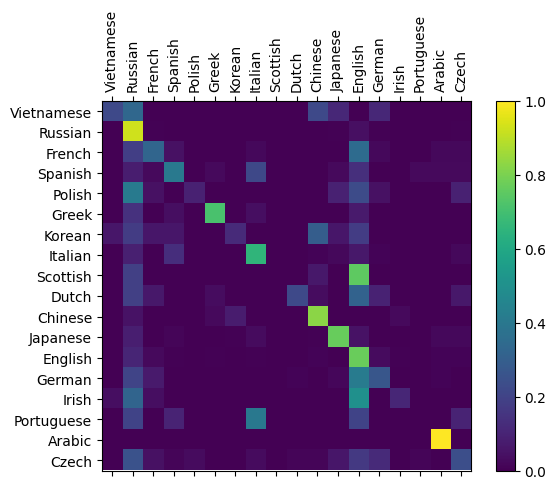

In [14]:
def evaluate(rnn: CharRNN, testing_data: torch.utils.data.Subset, classes: List[str]) -> None:
    """Evaluate the model and display a confusion matrix."""
    confusion: torch.Tensor = torch.zeros(len(classes), len(classes))
    
    rnn.eval()
    with torch.no_grad():
        for i in range(len(testing_data)):
            label_tensor: torch.Tensor
            text_tensor: torch.Tensor
            label: str
            text: str
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output: torch.Tensor = rnn(text_tensor)
            guess: str
            guess_i: int
            guess, guess_i = label_from_output(output, classes)
            label_i: int = classes.index(label)
            confusion[label_i][guess_i] += 1
    
    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom: torch.Tensor = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom
    
    # Set up plot
    fig: plt.Figure = plt.figure(figsize=(10, 10))
    ax: plt.Axes = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy())
    fig.colorbar(cax)
    
    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)
    
    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.tight_layout()
    plt.show()
    plt.close(fig)
    
evaluate(rnn, test_set, classes=alldata.labels_uniq)